# Analysis 2.2
- Outcome: ugica over 10 years
- Model: Individual log reg models for each subtype 
- Feature selection: Significant variables based on univariate analysis
- Predicts 10 year risk for combined UGI cancer outcome based on additive risk from subtype-specific models 
- Risk score threshold determined on 1) optimal threshold 

## Import libraries

In [18]:
%load_ext rpy2.ipython 
# Load the R magic extension

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
source("utils.R")
library(survival)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [8]:
model = 'logreg'
analysis_num = '2.2'
outcome_interval = "_10yr"

outcome_event = f'ugica{outcome_interval}'
subtypes = [f'escc{outcome_interval}', f'eac{outcome_interval}', f'ncgc{outcome_interval}', f'cgc{outcome_interval}']


In [9]:
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_all_subtypes.csv'
json_filename = './../notebook/thresholds.json'

ro.globalenv['subtypes'] = list(subtypes)
ro.globalenv['subtypes'] = list(subtypes)
ro.globalenv['outcome_event'] = outcome_event

In [10]:
# Load the JSON file
with open(json_filename, "r") as f:
    model_variables = json.load(f)

## Import each subtype-specific model and the variables for each model

In [11]:
selected_vars = set()
for subtype in subtypes:
    model_vars = set(model_variables[model][subtype]['variables'])
    selected_vars.update(model_vars)
    print(subtype, model_vars)

ro.globalenv['selected_vars'] = list(selected_vars)
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean'] # Needed to factorize categorical vars later

escc_10yr {'pud', 'famhx_colonca', 'PPI', 'ASA', 'NSAID', 'ethnicity', 'tobacco_binary', 'hnca', 'gerd', 'famhx_cancer', 'BMI_baseline_all', 'age', 'cad'}
eac_10yr {'pud', 'PPI', 'famhx_gastricca', 'race_clean', 'ethnicity', 'tobacco_binary', 'sex_missing', 'hnca', 'gerd', 'famhx_cancer', 'age', 'cad'}
ncgc_10yr {'pud', 'PPI', 'ASA', 'NSAID', 'famhx_gastricca', 'race_clean', 'ethnicity', 'tobacco_binary', 'sex_missing', 'hnca', 'gerd', 'famhx_cancer', 'age', 'cad'}
cgc_10yr {'pud', 'PPI', 'ASA', 'NSAID', 'famhx_gastricca', 'race_clean', 'ethnicity', 'tobacco_binary', 'sex_missing', 'famhx_cancer', 'age', 'cad'}


In [12]:
for subtype in subtypes: 
    model_name = f'logreg_{subtype}.rds'
    ro.globalenv[f'logreg_{subtype}'] = model_name

## Factorize categorical vars and set reference levels

In [13]:
%%R
# Remove categorical variables that we do not want to include in analysis
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')

## Partition data

In [14]:
%%R 
unlist(selected_vars)

 [1] "pud"              "famhx_colonca"    "NSAID"            "race_clean"      
 [5] "tobacco_binary"   "sex_missing"      "gerd"             "famhx_cancer"    
 [9] "BMI_baseline_all" "ASA"              "cad"              "PPI"             
[13] "famhx_gastricca"  "ethnicity"        "hnca"             "age"             


In [15]:
%%R 
selected_vars <- unlist(selected_vars) # Convert from list to a character vector 

# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set


[1] "Dataset Controls 33890" "Dataset Cases 293"     
[1] "Training Controls 27115" "Training Cases 232"     
[1] "Validation Controls 6775" "Validation Cases 61"     



## Results

### Estimate risk for each subtype and add to get combined ugica risk

In [16]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
risk_col_subtypes <- c() 

# Get the predicted risk 
for (subtype in subtypes) {
    # Load x model for that subtype 
    model_name <- paste0('logreg_', subtype, '.RDS')
    model <- readRDS(model_name)

    # Predict risk of that subtype
    pred_risk <- calculate_risk_from_logreg(model, validation_set)

    # Save risk column
    risk_col_name <- paste0('pred_risk_', subtype)
    risk_col_subtypes <- c(risk_col_subtypes, risk_col_name)
    r_df_validation_risk[[risk_col_name]] <- pred_risk
}

r_df_validation_risk$pred_risk_cum <- rowSums(r_df_validation_risk[, risk_col_subtypes])
names(r_df_validation_risk)

 [1] "time"                "event_ugica"         "event_escc"         
 [4] "event_eac"           "event_cgc"           "event_ncgc"         
 [7] "race"                "sex"                 "age_bucket"         
[10] "visit_year_bucket"   "ugica_5yr"           "escc_5yr"           
[13] "eac_5yr"             "cgc_5yr"             "ncgc_5yr"           
[16] "ugica_1yr"           "escc_1yr"            "eac_1yr"            
[19] "cgc_1yr"             "ncgc_1yr"            "ugica_3yr"          
[22] "escc_3yr"            "eac_3yr"             "cgc_3yr"            
[25] "ncgc_3yr"            "ugica_10yr"          "escc_10yr"          
[28] "eac_10yr"            "cgc_10yr"            "ncgc_10yr"          
[31] "pred_risk_escc_10yr" "pred_risk_eac_10yr"  "pred_risk_ncgc_10yr"
[34] "pred_risk_cgc_10yr"  "pred_risk_cum"      


### Sensitivity and Metrics at 70% specificity

In [19]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])

pred_risk <- r_df_validation_risk$pred_risk_cum
actual_event <- r_df_validation_risk[[outcome_event]]

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(pred_risk, probs = percentile / 100)
calculate_cm_by_percentile(pred_risk, actual_event, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.768 
Sensitivity: 0.7213115 
Specificity: 0.7037638 
PPV: 0.02145295 
NPV: 0.9964472 
NNS: 55.86536 
     predicted_class
event    0    1
    0 4768 2007
    1   17   44


### Sensitivity and Metrics at threshold that maximizes Youdens

In [20]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = actual_event, predictor = pred_risk)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(pred_risk, actual_event, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.768 
Sensitivity: 0.7213115 
Specificity: 0.7061255 
PPV: 0.02162162 
NPV: 0.9964591 
NNS: 55.30762 
     predicted_class
event    0    1
    0 4784 1991
    1   17   44


### AUROC curves and PR curve

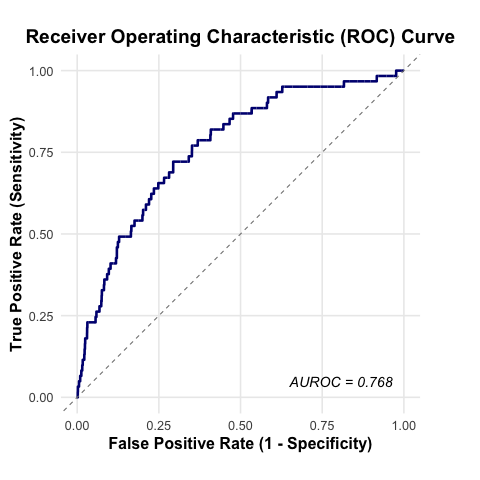

In [22]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(actual_event, pred_risk)
p2 <- plot_pr_gg(actual_event, pred_risk)

p1

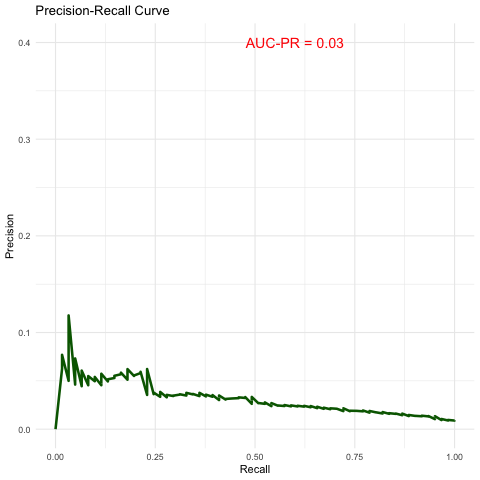

In [23]:
%%R
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [24]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk_cum'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [25]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,ugica_10yr,escc_10yr,eac_10yr,cgc_10yr,ncgc_10yr,pred_risk_escc_10yr,pred_risk_eac_10yr,pred_risk_ncgc_10yr,pred_risk_cgc_10yr,pred_risk_cum,actual_percentile,risk_group,risk_p0.5,risk_p0.6,risk_p0.7,risk_p0.7023112931538911,risk_p0.75,risk_p0.8,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000367,0.000700,0.001914,0.000581,0.003562,0.321826,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000148,0.000366,0.002153,0.000107,0.002774,0.217086,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000252,0.013414,0.002816,0.003540,0.020022,0.915594,0.9,1,1,1,1,1,1,1,1,0,0,0,0,1,1
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000210,0.000215,0.002803,0.000314,0.003541,0.319193,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003456,0.008496,0.003594,0.008229,0.023776,0.942803,0.9,1,1,1,1,1,1,1,1,0,0,0,0,1,1


In [26]:
outcome_event

'ugica_10yr'

In [27]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [28]:
df_results.tail(5)

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,ugica_10yr,70-79,1946,14,605,8 (1.3%),1.3,8,597,6,1349,0.692347,0.307653,57.142857,69.321686,1.322314,99.557196,113.699723,0.264645
71,high_risk_youden,youden,ugica_10yr,50-59,1257,14,361,10 (2.8%),2.8,10,351,4,906,0.720692,0.279308,71.428571,72.076372,2.770083,99.560440,42.908830,0.435049
72,high_risk_youden,youden,ugica_10yr,2011-2014,2840,28,891,19 (2.1%),2.1,19,872,9,1968,0.692817,0.307183,67.857143,69.295775,2.132435,99.544765,59.623172,0.371529
73,high_risk_youden,youden,ugica_10yr,2015-2018,2270,30,760,23 (3.0%),3.0,23,737,7,1533,0.676522,0.323478,76.666667,67.533040,3.026316,99.545455,38.883721,0.441997
74,high_risk_youden,youden,ugica_10yr,2019-2022,1665,3,384,2 (0.5%),0.5,2,382,1,1283,0.770384,0.229616,66.666667,77.057057,0.520833,99.922118,225.758242,0.437237


In [29]:
df_results.to_csv(risk_results_filename)

### Prevalance of cancer as a function of risk percentile by subtype

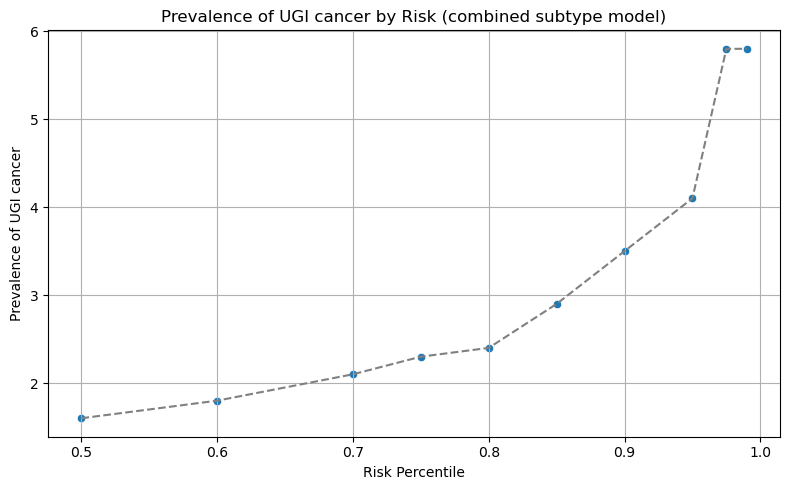

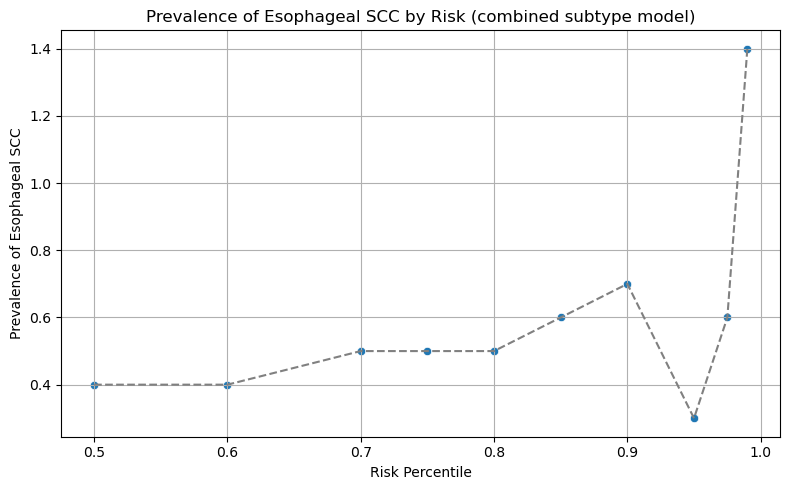

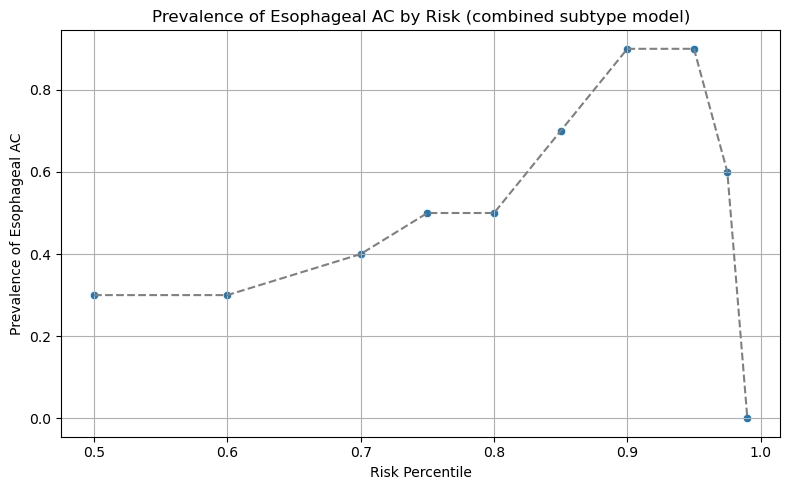

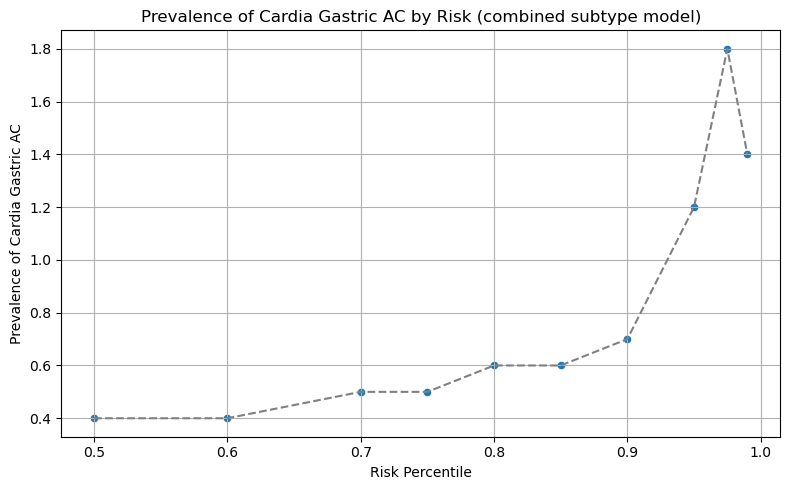

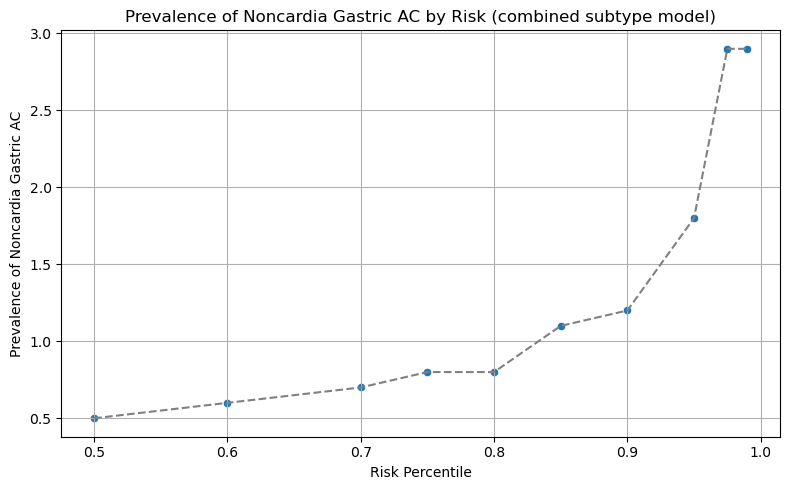

In [30]:
event_pretty_label = {
    f'ugica{outcome_interval}': "UGI cancer", 
    f'escc{outcome_interval}': "Esophageal SCC",
    f'eac{outcome_interval}': "Esophageal AC",
    f'cgc{outcome_interval}': "Cardia Gastric AC",
    f'ncgc{outcome_interval}': "Noncardia Gastric AC"
}

df_results_plot = df_results[~df_results['risk_percentile'].isin(['youden', optimal_threshold_percentile])]

for event in events:
    # Plot the scatterplot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence')

    # Optionally add a line to show trend
    sns.lineplot(data=df_results_plot[df_results_plot.event == event], x='risk_percentile', y='prevalence', color='gray', linestyle='--')

    plt.xlabel("Risk Percentile")
    #plt.xticks(ticks=range(len(percentile_cutoffs)-1), labels=percentile_cutoffs[1:])
    plt.ylabel(f'Prevalence of {event_pretty_label[event]}')
    plt.title(f'Prevalence of {event_pretty_label[event]} by Risk (combined subtype model)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Kaplan Meier survival curves stratified by risk group

In [31]:
pd.crosstab(df_validation_risk.ugica_5yr, df_validation_risk.high_risk_youden)

high_risk_youden,0,1
ugica_5yr,,
0.0,4792,2004
1.0,9,31


In [32]:
# Pass dataframe to R to analyze
ro.globalenv['r_df_validation_risk'] = df_validation_risk

/Users/alyssa.chen/miniconda3/envs/rpy2_env/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "risk_group". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


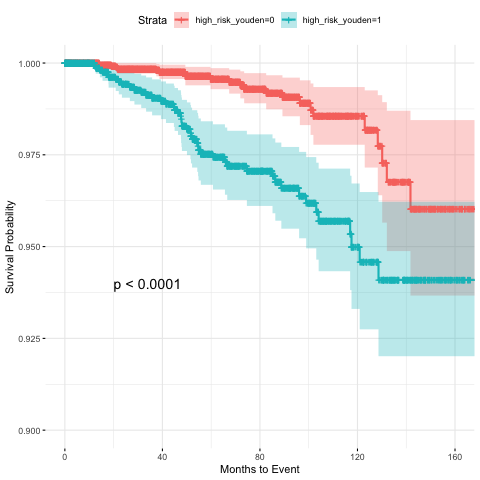

In [33]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event_ugica)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.94),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.90, 1),
    ggtheme = theme_minimal()
)

g$plot